In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import ParameterGrid

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# ==== Load and Prepare Data ====
samples = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_dataframe_proc.csv')
tests = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_tests_proc.csv')

X_train = samples.iloc[:, :-1]
y_train = samples.iloc[:, -1]
X_test = tests.iloc[:, :-1]
y_test = tests.iloc[:, -1]

# Upsample minority class
df = pd.concat([X_train, y_train], axis=1)
normal = df[df['Label'] == 0]
ddos = df[df['Label'] == 1]
normal_upsampled = resample(normal, replace=True, n_samples=len(ddos), random_state=27)
upsampled = pd.concat([normal_upsampled, ddos])
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

# Normalize
scaler = MinMaxScaler((-1, 1)).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# ==== Define DNN Model ====
def DNN_model(input_size):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_size,)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [6]:
# ==== Evaluation Function ====
def full_evaluation(model, X_train, y_train, X_test, y_test, epochs, batch_size, learning_rate):
    start_time = time.time()
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    train_time = time.time() - start_time

    # Dự đoán xác suất
    y_prob = model.predict(X_test).flatten()

    # Dự đoán nhị phân
    y_pred = (y_prob > 0.5).astype(int)

    # Detection rates
    true_normal = (y_test == 0)
    true_attack = (y_test == 1)
    normal_detect_rate = (y_pred[true_normal] == 0).sum() / true_normal.sum()
    attack_detect_rate = (y_pred[true_attack] == 1).sum() / true_attack.sum()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # ROC Curve and AUC - dùng xác suất
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Normal_Detect_Rate': normal_detect_rate,
        'Atk_Detect_Rate': attack_detect_rate,
        'Training_Time': train_time,
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'Confusion_Matrix': cm.tolist(),
        'ROC_FPR': fpr.tolist(),
        'ROC_TPR': tpr.tolist(),
        'ROC_AUC': roc_auc
    }


# ==== Grid Search ====
param_grid = {
    'epochs': [5, 10],
    'batch_size': [64, 128],
    'learning_rate': [0.001, 0.0005]
}

results = []
for params in ParameterGrid(param_grid):
    print(f"Training DNN with params: {params}")
    model = DNN_model(X_train.shape[1])
    result = full_evaluation(
        model, X_train, y_train,
        X_test, y_test,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate']
    )
    results.append(result)


Training DNN with params: {'batch_size': 64, 'epochs': 5, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 5s 480us/step
Training DNN with params: {'batch_size': 64, 'epochs': 5, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 5s 436us/step
Training DNN with params: {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 5s 454us/step
Training DNN with params: {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 5s 449us/step
Training DNN with params: {'batch_size': 128, 'epochs': 5, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 6s 574us/step
Training DNN with params: {'batch_size': 128, 'epochs': 5, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 5s 504us/step
Training DNN with params: {'batch_size': 128, 'epochs': 10, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 5s 444us/step
Training DNN with params: {'batch_size': 128, 'epochs': 10, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 5s 459us/step


In [38]:
# ==== Save All Results (excluding ROC) ====
df_results_dnn = pd.DataFrame([
    {k: v for k, v in res.items() if k not in ['ROC_FPR', 'ROC_TPR']} for res in results
])

df_results_dnn.to_csv(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\DNN\dnn_gridsearch_results.csv', index=False)

# ==== Save Best Model Result ====
best_index = df_results_dnn['Accuracy'].idxmax()
best_model_result = results[best_index]  # Lấy bản đầy đủ để có ROC
best_model_df = pd.DataFrame([{
    k: v for k, v in best_model_result.items() if k not in ['ROC_FPR', 'ROC_TPR']
}])

print("\nBest Hyperparameters (DNN - Highest Accuracy):")
for param in best_model_df.columns:
    print(f"{param}: {best_model_df[param][0]}")

best_model_df.to_csv(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\DNN\dnn_best_results.csv', index=False)
# ==== Save ROC for Best Model ====
np.save(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\DNN\best_model_roc_fpr.npy', np.array(best_model_result['ROC_FPR']))
np.save(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\DNN\best_model_roc_tpr.npy', np.array(best_model_result['ROC_TPR']))
np.save(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\DNN\best_model_roc_auc.npy', best_model_result['ROC_AUC'])



Best Hyperparameters (DNN - Highest Accuracy):
Accuracy: 0.99928318558179
Precision: 0.9993017004821425
Recall: 0.9998384973229176
F1-Score: 0.9995700268338356
Normal_Detect_Rate: 0.996506626876152
Atk_Detect_Rate: 0.9998384973229176
Training_Time: 77.10127782821655
epochs: 10
batch_size: 128
learning_rate: 0.001
Confusion_Matrix: [[56766, 199], [46, 284779]]
ROC_AUC: 0.999959515671629


In [4]:
# Read the results into a DataFrame (for plotting purposes only)
grid_df = pd.read_csv(r"dnn_gridsearch_results.csv")

In [5]:
grid_df = pd.DataFrame(grid_df)
print("==== Grid Search Results for DNN ====")
grid_df

==== Grid Search Results for DNN ====


,Accuracy,Precision,Recall,F1-Score,Normal_Detect_Rate,Atk_Detect_Rate,Training_Time,epochs,batch_size,learning_rate,Confusion_Matrix,ROC_AUC
0,0.999149,0.999133,0.999846,0.999489,0.995664,0.999846,69.187624,5,64,0.0010,"[[56718, 247], [44, 284781]]",0.999827
1,0.998833,0.999308,0.999291,0.999300,0.996542,0.999291,74.985639,5,64,0.0005,"[[56768, 197], [202, 284623]]",0.999910
2,0.999143,0.999112,0.999860,0.999486,0.995559,0.999860,145.178560,10,64,0.0010,"[[56712, 253], [40, 284785]]",0.999944
3,0.999184,0.999126,0.999895,0.999510,0.995629,0.999895,155.020833,10,64,0.0005,"[[56716, 249], [30, 284795]]",0.999814
4,0.999134,0.999126,0.999835,0.999481,0.995629,0.999835,50.982044,5,128,0.0010,"[[56716, 249], [47, 284778]]",0.999919
5,0.999178,0.999137,0.999877,0.999507,0.995682,0.999877,39.676002,5,128,0.0005,"[[56719, 246], [35, 284790]]",0.999891
6,0.999283,0.999302,0.999838,0.999570,0.996507,0.999838,77.101278,10,128,0.0010,"[[56766, 199], [46, 284779]]",0.999960
7,0.999005,0.999182,0.999624,0.999403,0.995910,0.999624,84.302672,10,128,0.0005,"[[56732, 233], [107, 284718]]",0.999910


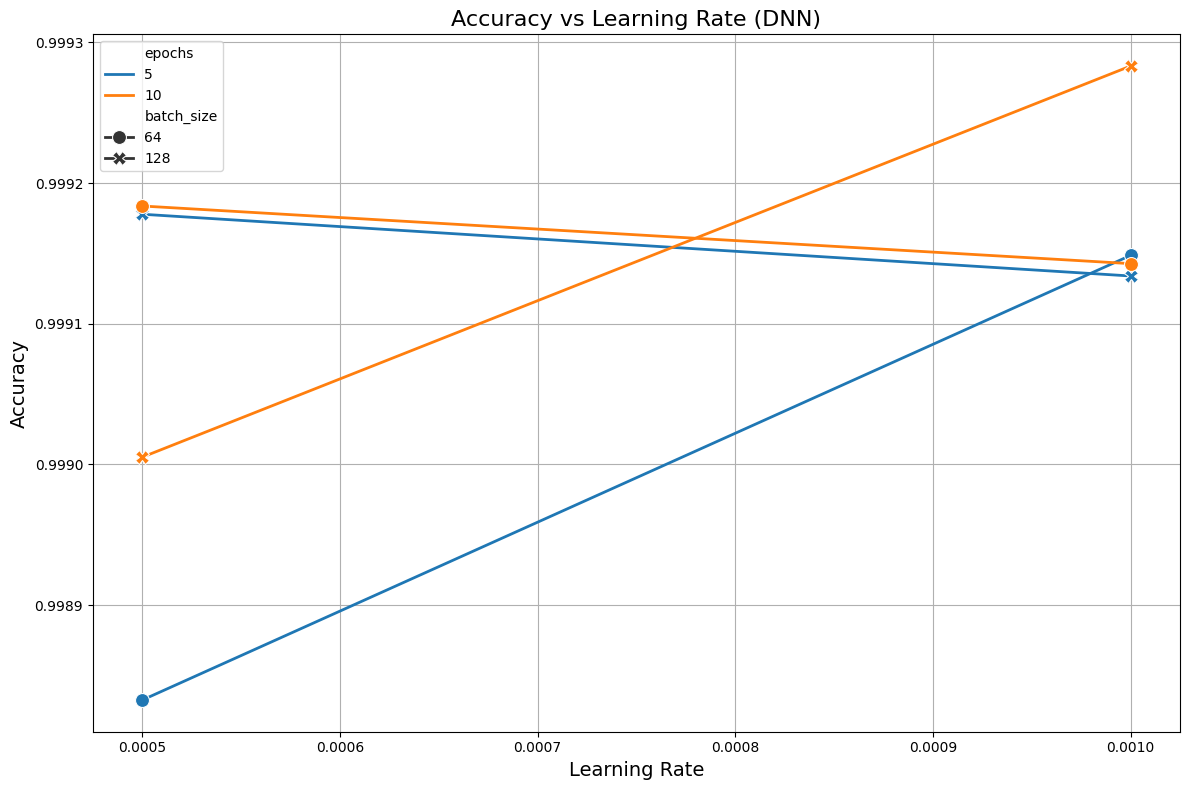

In [4]:
plt.figure(figsize=(12, 8))

# Plot Accuracy vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Accuracy',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',  # Different palette for Accuracy
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Adding title and labels for Accuracy plot
plt.title("Accuracy vs Learning Rate (DNN)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Adjust grid and layout for Accuracy plot
plt.grid(True)
plt.tight_layout()

# Show the Accuracy plot
plt.show()

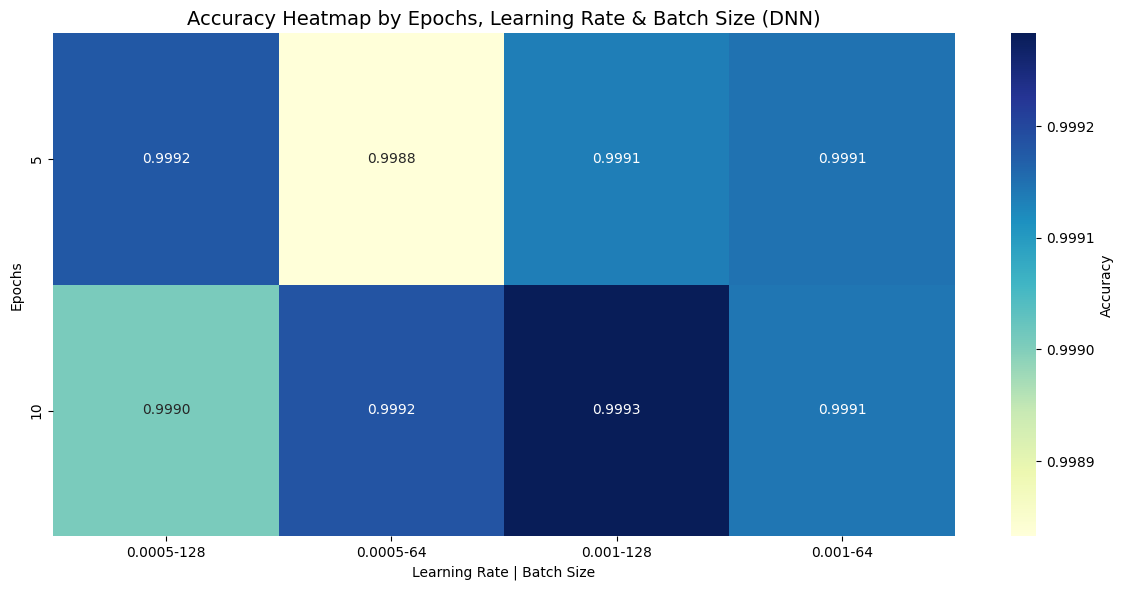

In [7]:
grid_df['learning_rate'] = grid_df['learning_rate'].astype(str)
grid_df['batch_size'] = grid_df['batch_size'].astype(str)

# Create a pivot table with MultiIndex columns: (learning_rate, batch_size)
heatmap_data = grid_df.pivot_table(
    index='epochs',
    columns=['learning_rate', 'batch_size'],
    values='Accuracy',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Accuracy'}
)

plt.title("Accuracy Heatmap by Epochs, Learning Rate & Batch Size (DNN)", fontsize=14)
plt.xlabel("Learning Rate | Batch Size")
plt.ylabel("Epochs")
plt.tight_layout()
plt.show()

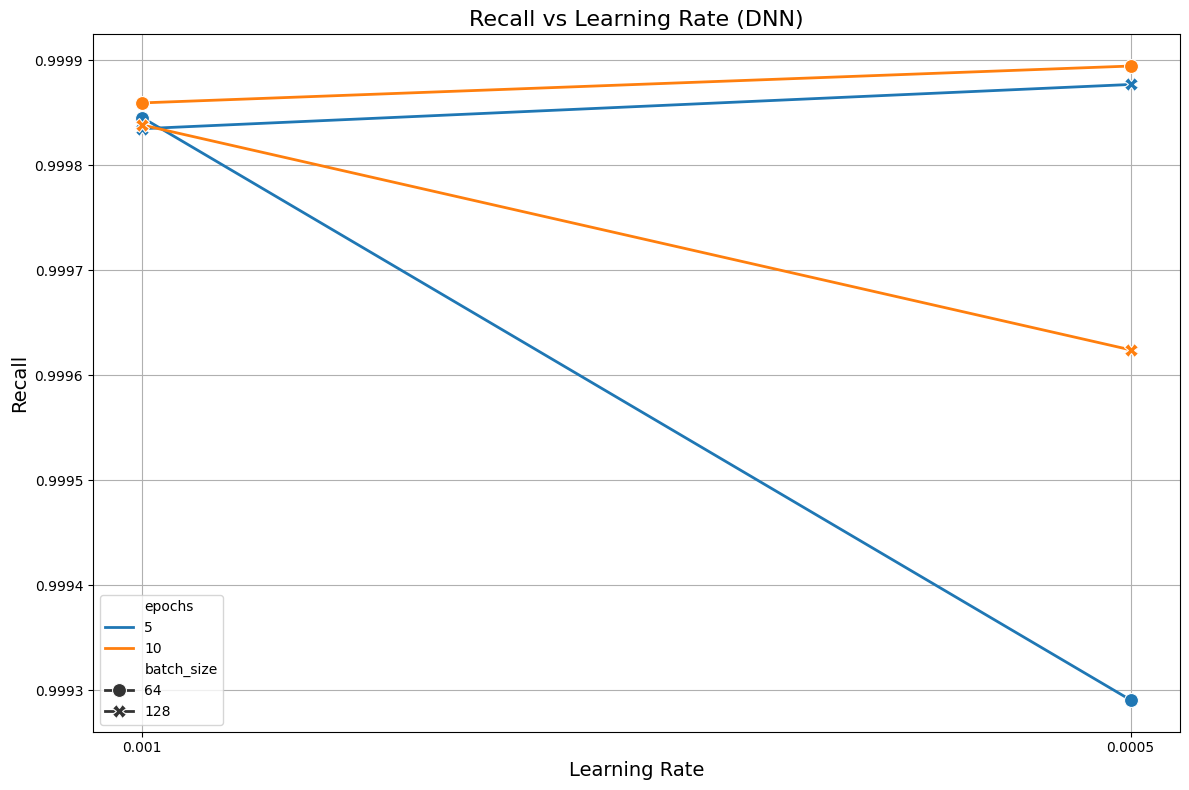

In [8]:
plt.figure(figsize=(12, 8))

# Plot Recall vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Recall',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Add title and labels
plt.title("Recall vs Learning Rate (DNN)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Recall", fontsize=14)

# Adjust grid and layout
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

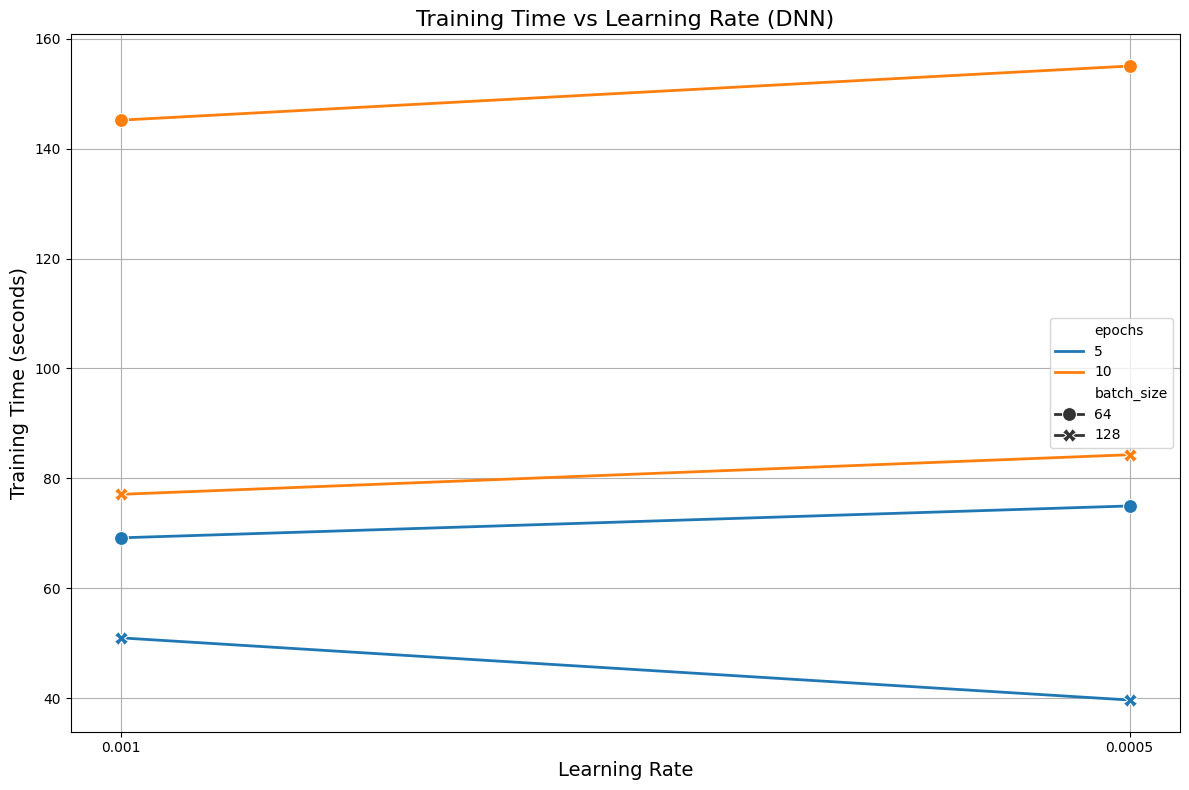

In [9]:
plt.figure(figsize=(12, 8))

# Plot Training Time vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Training_Time',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Add title and labels
plt.title("Training Time vs Learning Rate (DNN)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Training Time (seconds)", fontsize=14)

# Adjust grid and layout
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

BEST MODEL

In [10]:
best_model = grid_df.loc[grid_df['Accuracy'].idxmax()]
print("Best Model Parameters:")
print(best_model)

Best Model Parameters:
Accuracy                                  0.999283
Precision                                 0.999302
Recall                                    0.999838
F1-Score                                   0.99957
Normal_Detect_Rate                        0.996507
Atk_Detect_Rate                           0.999838
Training_Time                            77.101278
epochs                                          10
batch_size                                     128
learning_rate                                0.001
Confusion_Matrix      [[56766, 199], [46, 284779]]
ROC_AUC                                    0.99996
Name: 6, dtype: object


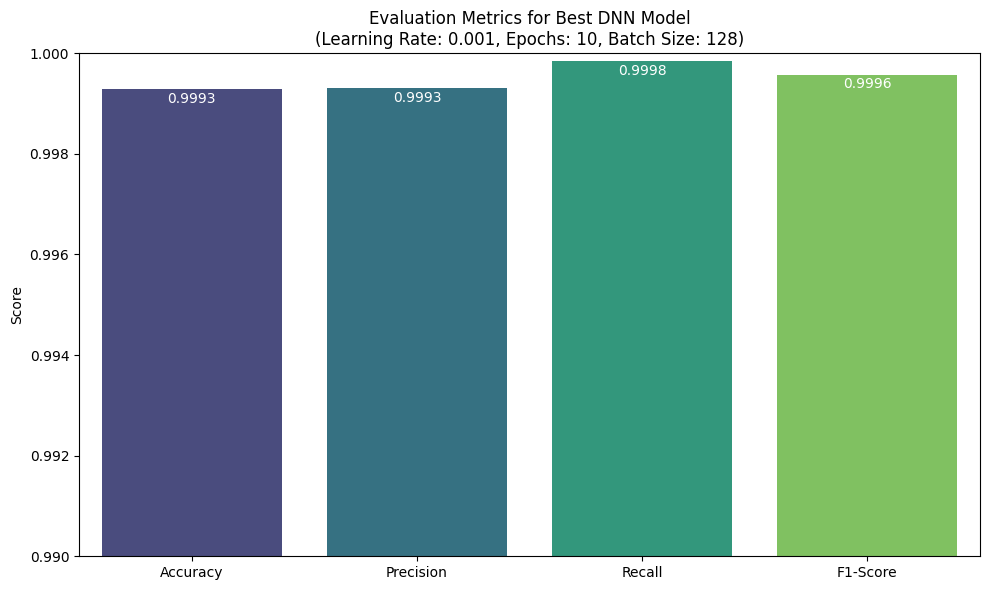

In [11]:
# Prepare evaluation metrics for plotting (CNN)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [best_model['Accuracy'], best_model['Precision'], best_model['Recall'], best_model['F1-Score']]

# Plot the evaluation metrics as a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, hue=metrics, palette='viridis', legend=False)

# Add labels inside the bars, closer to the top
for i, value in enumerate(values):
    plt.text(i, value - 0.00005 , f'{value:.4f}', ha='center', va='top', color='white')

# Set the y-axis to start from 0.99
plt.ylim(0.99, 1.0)

# Add plot title and labels — updated for CNN
plt.title(
    f"Evaluation Metrics for Best DNN Model\n"
    f"(Learning Rate: {best_model['learning_rate']}, Epochs: {best_model['epochs']}, Batch Size: {best_model['batch_size']})"
)
plt.ylabel("Score")
plt.tight_layout()
plt.show()

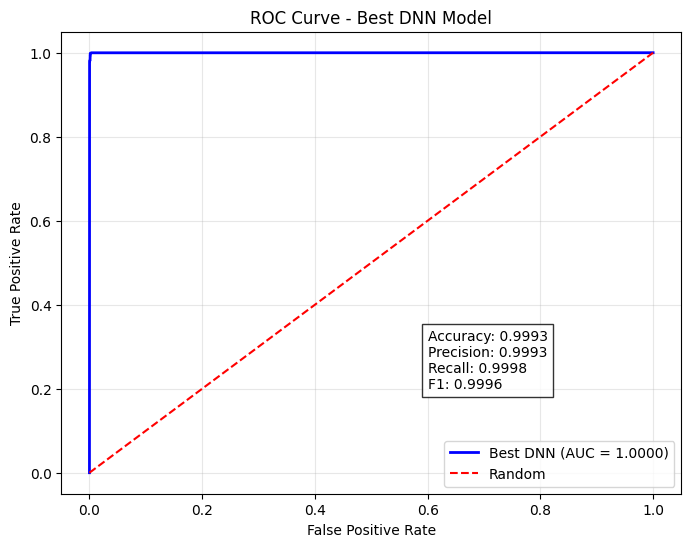

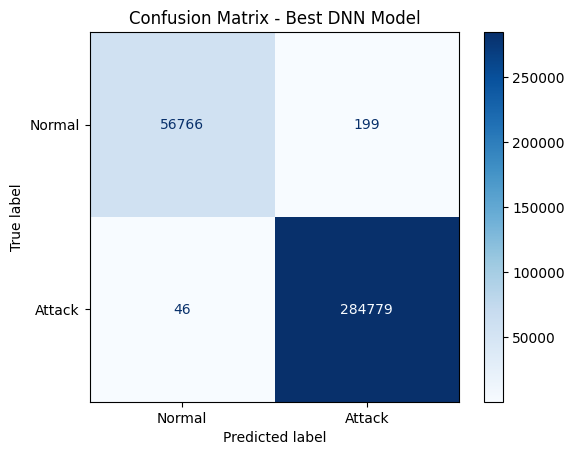

In [ ]:
# ==== Load ROC ====
best_model_roc_fpr = np.load(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\DNN\best_model_roc_fpr.npy', allow_pickle=True)
best_model_roc_tpr = np.load(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\DNN\best_model_roc_tpr.npy', allow_pickle=True)
best_model_roc_auc = np.load(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\DNN\best_model_roc_auc.npy', allow_pickle=True)

# ==== ROC Curve ====
plt.figure(figsize=(8, 6))
plt.plot(best_model_roc_fpr, best_model_roc_tpr, 'b-', linewidth=2, label=f'Best DNN (AUC = {best_model_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best DNN Model')
plt.legend()
plt.grid(alpha=0.3)

plt.text(0.6, 0.2, f'Accuracy: {best_model_df["Accuracy"].values[0]:.4f}\n'
                   f'Precision: {best_model_df["Precision"].values[0]:.4f}\n'
                   f'Recall: {best_model_df["Recall"].values[0]:.4f}\n'
                   f'F1: {best_model_df["F1-Score"].values[0]:.4f}',
         bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# ==== Confusion Matrix ====
cm = np.array(best_model_result['Confusion_Matrix'])  
if cm.ndim == 3:  
    cm = cm[0]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best DNN Model')
plt.grid(False)
plt.show()